In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('..')
%load_ext autoreload
%autoreload 2

Deep neural networks have shown staggering performances in various learning tasks, including computer vision, natural language processing, and sound processing. They have made the model design more flexible by enabling end-to-end training.

In this exercise, we get to have a first hands-on experience with neural network training. Many frameworks (e.g., PyTorch, Tensorflow, Caffe) allow easy usage of deep neural networks without precise knowledge of the inner workings of backpropagation and gradient descent algorithms. While these are very useful tools, it is important to get a good understanding of how to implement basic network training from scratch before using these libraries to speed up the process. For this purpose, we will implement a simple two-layer neural network and its training algorithm based on back-propagation using only basic matrix operations in questions 1 to 3. In question 4, we will use a popular deep learning library, PyTorch, to do the same and understand the advantages offered by using such tools.

As a benchmark to test our models, we consider an image classification task using the widely used CIFAR-10 dataset. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to code and train a parametrized model for classifying those images. This involves

- Implementing the feedforward model (Question 1).
- Implementing the backpropagation algorithm (gradient computation) (Question 2).
- Training the model using stochastic gradient descent and improving the model training with better hyper-parameters (Question 3).
- Using the PyTorch Library to implement the above and experiment with deeper networks (Question 4).
- Refactoring the code into a modular Trainer class that takes care of everything (Question 5).

A note on notation: Throughout the exercise, notation $v_i$ is used to denote the $i$-th element of vector $v$.

### Question 1: Implementing the feedforward model (10 points)

In this question, we will implement a two-layered neural network architecture and the loss function to train it.

![](../../data/exercise-2/fig1.png)

**Model architecture.** Our architecture is shown in Fig.1. It has an input layer and two model layers – a hidden and an output layer. We start with randomly generated toy inputs of four dimensions and the number of classes K = 3 to build our model in Q1 and Q2, and in Q3 use images from the CIFAR-10 dataset to test our model on a real-world task. Hence input layer is 4-dimensional for now.

In the hidden layer, there are 10 units. The input layer and the hidden
layer are connected via linear weighting matrix $W^{(1)}\in\mathbb{R}^{10\times
4}$ and the bias term $b^{(1)}\in\mathbb{R}^{10}$. The parameters $W^{(1)}$
and $b^{(1)}$ are to be learnt later on. A linear operation is performed,
$W^{(1)}x+b^{(1)}$, resulting in a 10 dimensional vector $z^{(2)}$. It is then
followed by a relu non-linear activation $\phi$, applied element-wise on each
unit, resulting in the activations $a^{(2)} = \phi(z^{(2)})$. Relu function has
the following form:

\begin{equation}
\phi(u) =  \begin{cases}
      u, & \text{if}\ u\geq0 \\
      0, & \text{if}\ u <0
    \end{cases}
\end{equation}

A similar linear operation is performed on $a^{(2)}$, resulting in $z^{(3)}=W^{(2)}a^{(2)}+b^{(2)}$, where $W^{(2)}\in\mathbb{R}^{3\times 10}$ and $b^{(2)}\in\mathbb{R}^{3}$; it is followed by the softmax activation to result in $a^{(3)}=\psi(z^{(3)})$. The softmax function is defined by:
\begin{equation}
\psi(u)_i =  \frac{\exp^{u_i}}{\sum_j{\exp^{u_j}}} 
\end{equation}

The final functional form of our model is thus defined by

\begin{align*}
a^{(1)} &= x \\ \
z^{(2)} &= W^{(1)}a^{(1)}+b^{(1)} \\
a^{(2)} &= \phi(z^{(2)}) \\
z^{(3)} &= W^{(2)}a^{(2)}+b^{(2)} \\
f_\theta(x) := a^{(3)} &= \psi(z^{(3)}),
\end{align*}

which takes a flattened 4 dimensional vector as input and outputs a $3$ dimensional vector, each entry in the output $f_k(x)$ representing the probability of image $x$ corresponding to the class $k$. We summarily indicate all the network parameters by $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.

**Implementation.** We are now ready to implement the feedforward neural network.

a) Implement the feedforward model. Verify that the scores you generate for the toy inputs match the correct scores. (5 points)

In [9]:
import models.twolayernet.model as module_twolayernet
from utils.utils import seed_everything, init_toy_data, rel_error
from utils.gradient_check import eval_numerical_gradient

In [10]:
seed_everything(1)

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

net = module_twolayernet.TwoLayerNetv1(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, std=1e-1)
X, y = init_toy_data(num_inputs, input_size)

scores = net.forward(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
 [0.36446210, 0.22911264, 0.40642526],
 [0.47590629, 0.17217039, 0.35192332],
 [0.43035767, 0.26164229, 0.30800004],
 [0.41583127, 0.29832280, 0.28584593],
 [0.36328815, 0.32279939, 0.31391246]])
print(correct_scores)

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

assert math.isclose(np.sum(np.abs(scores - correct_scores)), 0,  abs_tol=1e-6)

Your scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Correct scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]
Difference between your scores and correct scores:
2.9173411408844885e-08


b) We later guide the neural network parameters
$\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$ to fit the given data and label
pairs. We do so by minimising the loss function. A popular choice of the loss
function for training neural networks for multi-class classification is the
cross-entropy loss. For a single input sample $x_i$, with label $y_i$, the loss
function is defined as:

\begin{align}
J(\theta, x_i, y_i) &= -\log{P(Y=y_i,X=x_i)} \\
                    &= -\log{f_\theta(x_i)_{y_i}} \\
                    &= -\log{\psi(z^{(3)})_{y_i}} \\
J(\theta, x_i, y_i) &= -\log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum^K_j{\exp^{z^{(3)}_j}}}\right]
\end{align}

Averaging over the whole training set, we get 

\begin{align}
J(\theta,\{x_i,y_i\}_{i=1}^{N}) = \frac{1}{N} \sum_{i=1}^N 
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right],
\end{align}

where $K$ is the number of classes. Note that if the model has perfectly fitted
to the data (i.e. $f_\theta^k(x_i)=1$ whenever $x_i$ belongs to class $k$ and 0
otherwise), then $J$ attains the minimum of $0$. 


Apart from trying to correctly predict the label, we have to prevent
overfitting the model to the current training data.  This is done by encoding
our prior belief that the correct model should be simple (Occam's razor); we
add an $L_2$ regularisation term over the model parameters $\theta$.
Specifically, the loss function is defined by:

\begin{align}
\tilde{J}(\theta) = \frac{1}{N} \sum_{i=1}^N
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right]
+\lambda \left(||W^{(1)}||_2^2 + ||W^{(2)}||_2^2 \right),
\end{align}

where $||\cdot||_2^2$ is the squared $L_2$ norm. For example,

\begin{align}
||W^{(1)}||_2^2 = 
\sum_{p=1}^{10} \sum_{q=1}^{4} W_{pq}^{(1)2}
\end{align}

By changing the value of $\lambda$ it is possible to give weights to your prior belief on the degree of simplicity (regularity) of the true model. 

Implement the final loss function and let it return the loss value. Verify the code by
running and matching the output cost $1.30378789133$. (5 points)

In [11]:
net_v2 = module_twolayernet.TwoLayerNetv2(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, std=1e-1) 
loss = net_v2.compute_loss(X, y, reg=0.05)
correct_loss = 1.30378789133 # check this number with your implementation

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

assert math.isclose(np.sum(np.abs(loss - correct_loss)), 0,  abs_tol=1e-6), 'The error with respect to the correct value is too high'

Difference between your loss and correct loss:
1.7963408538435033e-13


### Question 2: Backpropagation (15 points)

We train the model by solving
\begin{align}
\underset{\theta}{\min} \,\,  \tilde{J}(\theta)
\end{align}
via stochastic gradient descent. Therefore, We need an efficient computation of the gradients $\nabla_\theta \tilde{J}(\theta)$. We use backpropagation of top layer error signals to the parameters $\theta$ at different layers.

In this question, you will be required to implement the backpropagation algorithm yourself from pseudocode. We will give a high-level description of what is happening in each line.

For those who are interested in the robust derivation of the algorithm, we include the optional exercise on the derivation of the backpropagation algorithm. A piece of prior knowledge of standard vector calculus, including the chain rule, would be helpful.

**Backpropagation.** The backpropagation algorithm is simply a sequential application of the chain rule. It is applicable to any (sub-) differentiable model that is a composition of simple building blocks. In this exercise, we focus on the architecture with stacked layers of linear transformation + relu non-linear activation.

The intuition behind the backpropagation algorithm is as follows. Given a training example $(x, y)$, we first run the feedforward to compute all the activations throughout the network, including the output value of the model $f_\theta(x)$ and the loss $J$. Then, for each parameter in the model, we want to compute the effect that parameter has on the loss. This is done by computing the derivatives of the loss w.r.t for each model parameter.

The backpropagation algorithm is performed from the top of the network (loss layer) to the bottom. It sequentially computes the gradient of the loss function with respect to each layer's activations and parameters.

Let’s start by deriving the gradients of the un-regularized loss function w.r.t final layer activations $z^{(3)}$. We will then use this in the chain rule to compute analytical expressions for gradients of all the model parameters.

(a) Verify that the loss function (in Q1) has the gradient w.r.t $z^{(3)}$ as below.
\begin{equation}
\frac{\partial J}{\partial z^{(3)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) = \frac{1}{N}\left(\psi(z^{(3)}) - \Delta\right), 
\end{equation}
where $\Delta$ is a matrix of $N\times K$ dimensions with 
\begin{align}
        \Delta_{ij} = 1, & \text{if}\ y_i =j \\
                0, & \text{otherwise}
\end{align}
(please write your answer in the block below, or attach an image in the same cell, 2 points)

### Please refer to the pdf in "../../data/exercise-2/q2_pdf/HLCV_assignment.pdf" for continuous solution of Question 2. 

Page 1: 
![](../../data/exercise-2/q2_pdf/HLCV_assignment-1.jpg)
Page 2: 
![](../../data/exercise-2/q2_pdf/HLCV_assignment-2.jpg)
Page 3: 
![](../../data/exercise-2/q2_pdf/HLCV_assignment-3.jpg)

b) To compute the effect of the weight matrix $W^{(2)}$ on the loss (in Q1) incurred by the network, we compute the
partial derivatives of the loss function with respect to $W^{2}$.  This is done
by applying the chain rule. Verify that the partial derivative of the loss w.r.t $W^{(2)}$ is  

\begin{align}
\frac{\partial J}{\partial W^{(2)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) &= \frac{\partial J}{\partial z^{(3)}} \cdot \frac{\partial z^{(3)}}{\partial W^{(2)}} \\
&= \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'}
\end{align}

Similarly, verify that the regularized loss has the derivatives

\begin{align}
\frac{\partial \tilde{J}}{\partial W^{(2)}} = \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'} + 2\lambda W^{(2)}
\end{align}

(please write your answer in the block below, or attach an image in the same cell, 2 points)

Page 4: 
![](../../data/exercise-2/q2_pdf/HLCV_assignment-4.jpg)

c) We can repeatedly apply chain rule as discussed above to obtain the derivatives of the loss with respect to all the parameters of the model $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.
Dervive the expressions for the derivatives of the regularized loss (in Q1) w.r.t $W^{(1)}$, $b^{(1)}$, $b^{(2)}$ now.
(please write your answer in the block below, or attach an image in the same cell, 6 points)

Page 5: 
![](../../data/exercise-2/q2_pdf/HLCV_assignment-5.jpg)
Page 6: 
![](../../data/exercise-2/q2_pdf/HLCV_assignment-6.jpg)

d) Using the expressions you obtained for the derivatives of the loss w.r.t model parameters, implement the back-propagation algorithm. Run the code and verify that the gradients you obtained are correct using numerical gradients (already
implemented in the code). The maximum relative error between the gradients you compute and the numerical gradients should be less than 1e-8 for all parameters.
(5 points)

In [12]:
net_v3 = module_twolayernet.TwoLayerNetv3(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, std=1e-1)
loss, grads = net_v3.back_propagation(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net_v3.back_propagation(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net_v3.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.561318e-09
W2 max relative error: 3.440708e-09
b1 max relative error: 1.555471e-09
b2 max relative error: 3.865080e-11


### Question 3: Stochastic gradient descent training (10 points)

We have implemented the backpropagation algorithm for computing the parameter gradients and have verified that it indeed gives the correct gradient. We are now ready to train the network. We solve Eq.15 with the stochastic gradient descent.

Typically neural networks are large and are trained with millions of data
points. It is thus often infeasible to compute the gradient $\nabla_\theta
\tilde{J}(\theta)$ that requires the accumulation of the gradient over the
entire training set. Stochastic gradient descent addresses this problem by
simply accumulating the gradient over a small random subset of the training
samples (minibatch) at each iteration. Specifically, the algorithm is as
follows,

![](../../data/exercise-2/alg1.png)

where the gradient $\nabla_\theta \tilde{J}(\theta,\{(X^\prime_j,y^\prime_j)\}_{j=1}^B)$ is computed only on the current randomly sampled batch.

Intuitively, $v = -\nabla_\theta \tilde{J}(\theta^{(t-1)})$ gives the direction
to which the loss $\tilde{J}$ decreases the most (locally), and therefore we
follow that direction by updating the parameters towards that direction
$\theta^{(t)} = \theta^{(t-1)} + v$. 

a) Implement the stochastic gradient descent algorithm and run the training on the toy data. Your model
should be able to  obtain loss <= 0.02 on the training set and the training
curve should look similar to the one shown in figure 2.

![](../../data/exercise-2/fig2.png)

Final training loss:  0.017149607938732048


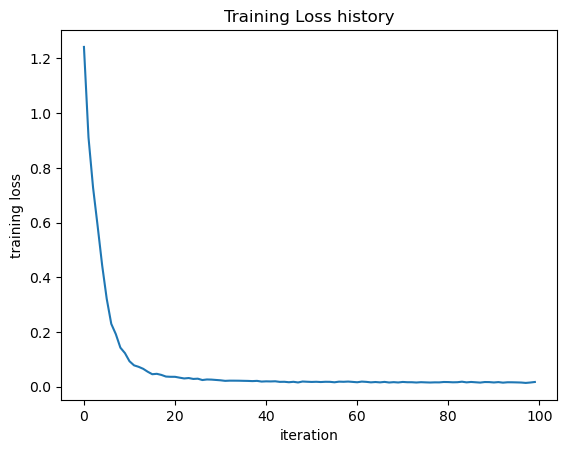

In [13]:
net_v4 = module_twolayernet.TwoLayerNetv4(input_size=input_size, hidden_size=hidden_size, output_size=num_classes, std=1e-1)
stats = net_v4.train(X, y, X, y,
                    learning_rate=1e-1, reg=5e-6,
                    num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

b) We are now ready to train our model on a real image dataset. For this, we will use
the CIFAR-10 dataset.  Since the images are of size $32\times 32$ pixels with 3
color channels, this gives us 3072 input layer units, represented by a vector
$x\in\mathbb{R}^{3072}$. The code to load the data and train the model is provided with
some default hyperparameters. With default
hyperparameters, if previous questions have been done correctly, you should get
a validation set accuracy of about 29\%. This is very poor.
Your task is to debug the model training and come up with better hyperparameters
to improve the performance on the validation set.
Visualize the training and validation performance curves to help with this analysis.
There are several pointers provided in the comments to 
help you understand why the network might be underperforming.
Once you have tuned your hyperparameters, and get validation accuracy greater
than 48\% run your best model on the test set once and report the performance.

**Download CIFAR-10 using this link: <http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz>**
<br/>
**Decompress the downloaded dataset, and put the `cifar-10-batches-py` folder in the folder `data/exercise-2`**

Please do not commit the dataset to git. This would make the repository unnecessarily large.

You can also try the next two commented lines (simply uncomment them and run the cell) for getting the dataset. The commands are tested on Linux

In [22]:
# !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xzf cifar-10-python.tar.gz -C ../../data/exercise-2

--2023-05-19 17:49:48--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  1.99MB/s    in 2m 1s   

2023-05-19 17:51:49 (1.35 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [5]:
from utils.utils import show_net_weights
from utils.data_utils import get_CIFAR10_data
from utils.vis_utils import visualize_grid

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


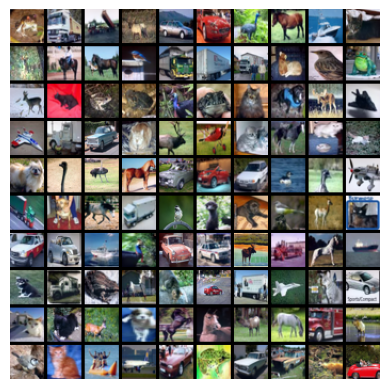

Validation accuracy:  0.2721.961350


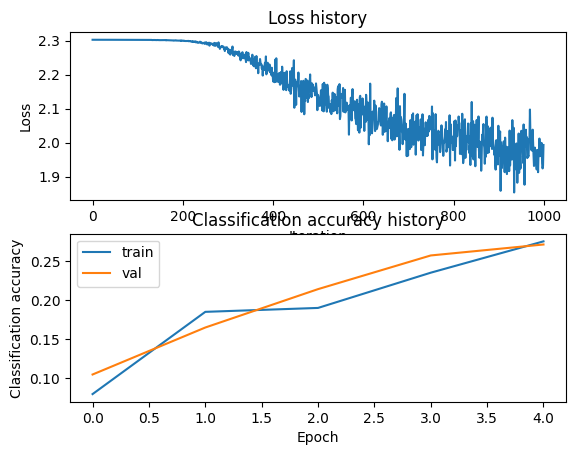

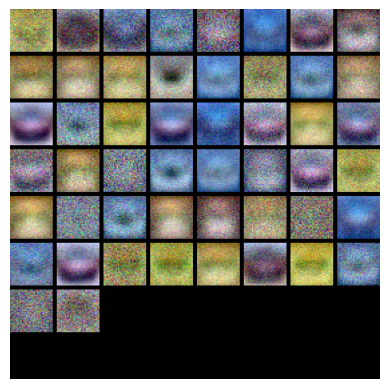

++++++++++++++++++++
{'batch_size_hyper': 128, 'hidden_size': 128, 'lr_hyper': 0.0007, 'num_iter_hyper': 25000, 'reg_hyper': 0.2}
Validation accuracy:  0.518ss 1.184226
++++++++++++++++++++
{'batch_size_hyper': 128, 'hidden_size': 128, 'lr_hyper': 0.0007, 'num_iter_hyper': 25000, 'reg_hyper': 0.3}
Validation accuracy:  0.542ss 1.278014
++++++++++++++++++++
{'batch_size_hyper': 128, 'hidden_size': 128, 'lr_hyper': 0.0007, 'num_iter_hyper': 25000, 'reg_hyper': 0.4}
Validation accuracy:  0.534ss 1.343734
++++++++++++++++++++
{'batch_size_hyper': 128, 'hidden_size': 128, 'lr_hyper': 0.0007, 'num_iter_hyper': 30000, 'reg_hyper': 0.2}
Validation accuracy:  0.529ss 1.267045
++++++++++++++++++++
{'batch_size_hyper': 128, 'hidden_size': 128, 'lr_hyper': 0.0007, 'num_iter_hyper': 30000, 'reg_hyper': 0.3}
Validation accuracy:  0.543ss 1.364116
++++++++++++++++++++
{'batch_size_hyper': 128, 'hidden_size': 128, 'lr_hyper': 0.0007, 'num_iter_hyper': 30000, 'reg_hyper': 0.4}
Validation accuracy:  0.5

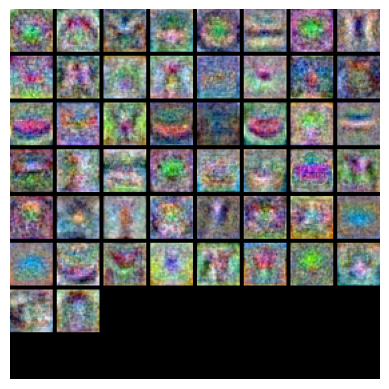

Test accuracy:  0.525


In [59]:
# # Load the data
# Now that you have implemented a two-layer network that passes
# gradient checks and works on toy data, it's time to load up our favorite
# CIFAR-10 data so we can use it to train a classifier on a real dataset.
# Invoke the get_CIFAR10_data function to get our data.

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some images to get a feel for the data
plt.imshow(visualize_grid(X_train[:100, :].reshape(100, 32,32, 3), padding=3).astype('uint8'))
plt.gca().axis('off')
plt.show()

# # Train a network
# To train our network we will use SGD. In addition, we will
# adjust the learning rate with an exponential learning rate schedule as
# optimization proceeds; after each epoch, we will reduce the learning rate by
# multiplying it by a decay rate.

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = module_twolayernet.TwoLayerNetv4(input_size=input_size, hidden_size=hidden_size, output_size=num_classes)
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



# # Debug the training
# With the default parameters we provided above, you should get a validation
# accuracy of about 0.29 on the validation set. This isn't very good.
#
# One strategy for getting insight into what's wrong is to plot the loss
# function and the accuracies on the training and validation sets during
# optimization.
#
# Another strategy is to visualize the weights that were learned in the first
# layer of the network. In most neural networks trained on visual data, the
# first layer weights typically show some visible structure when visualized.

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()


# Visualize the weights of the network

show_net_weights(net)

# # Tune your hyperparameters
#
# **What's wrong?**. Looking at the visualizations above, we see that the loss
# is decreasing more or less linearly, which seems to suggest that the learning
# rate may be too low. Moreover, there is no gap between the training and
# validation accuracy, suggesting that the model we used has low capacity, and
# that we should increase its size. On the other hand, with a very large model
# we would expect to see more overfitting, which would manifest itself as a
# very large gap between the training and validation accuracy.
#
# **Tuning**. Tuning the hyperparameters and developing intuition for how they
# affect the final performance is a large part of using Neural Networks, so we
# want you to get a lot of practice. Below, you should experiment with
# different values of the various hyperparameters, including hidden layer size,
# learning rate, numer of training epochs, and regularization strength. You
# might also consider tuning the learning rate decay, but you should be able to
# get good performance using the default value.
#
# **Approximate results**. You should aim to achieve a classification
# accuracy of greater than 48% on the validation set. Our best network gets
# over 52% on the validation set.
#
# **Experiment**: You goal in this exercise is to get as good of a result on
# CIFAR-10 as you can (52% could serve as a reference), with a fully-connected
# Neural Network. Feel free implement your own techniques (e.g. PCA to reduce
# dimensionality, or adding dropout, or adding features to the solver, etc.).

# **Explain your hyperparameter tuning process in the report.**

best_net = net # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters- by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from sklearn.model_selection import ParameterGrid
param_grid = {'num_iter_hyper': [25000, 30000], 
              'batch_size_hyper': [128,256,512],
              'lr_hyper': [0.7 * 1e-3, 0.9 * 1e-3],
              'reg_hyper': [0.20, 0.30,0.40],
              'hidden_size': [128,256]
              }
hyper_list = list(ParameterGrid(param_grid))
val_acc_list = []
for i in hyper_list:
    
    print("+"*20)
    print(i)
    net = module_twolayernet.TwoLayerNetv4(input_size=input_size, hidden_size=i['hidden_size'], output_size=num_classes)
    
    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=i['num_iter_hyper'], batch_size=i['batch_size_hyper'],
            learning_rate=i['lr_hyper'], learning_rate_decay=0.95,
            reg=i['reg_hyper'], verbose=True)
    
    val_acc = (net.predict(X_val) == y_val).mean()
    val_acc_list.append(val_acc)
    print('Validation accuracy: ', val_acc)
print("Best parameter on validation set from our search space:", hyper_list[np.argmax(val_acc_list)])

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# visualize the weights of the best network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=20000, batch_size=200,
            learning_rate=0.7 * 1e-3, learning_rate_decay=0.90,
            reg=0.20, verbose=True)


# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
show_net_weights(best_net)

# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

### <span style="color:red">Note: Please Read the following cells </span>.

- Tested the combination (72) of hyper-parameters and stored the val accuracy for multiple model's setting in val_acc_list.
- Now we will retrain the model with best hyper-parameter, worst hyper-parameter in the search space and default hyperparameter. We will plot the graphs for each case to understand more about it. 
- Finally, we will use these new model on test set for final evaluation. 

In [72]:
print("Best hyper-parameter on validation set from our search space:", hyper_list[np.argmax(val_acc_list)])
print("\nMax_Val_accuracy", np.max(val_acc_list))
print("\nWorst hyper-parameter on validation set from our search space:", hyper_list[np.argmin(val_acc_list)])
print("\nMin_Val_accuracy", np.min(val_acc_list))


Best hyper-parameter on validation set from our search space: {'batch_size_hyper': 512, 'hidden_size': 256, 'lr_hyper': 0.0007, 'num_iter_hyper': 30000, 'reg_hyper': 0.2}

Max_Val_accuracy 0.566

Worst hyper-parameter on validation set from our search space: {'batch_size_hyper': 128, 'hidden_size': 128, 'lr_hyper': 0.0009000000000000001, 'num_iter_hyper': 30000, 'reg_hyper': 0.3}

Min_Val_accuracy 0.507


### Report 

| S.No | Name          | Hyper-Parameters                                                                                               | Val Set Accuracy | Test Set Accuracy |
|------|---------------|----------------------------------------------------------------------------------------------------------------|------------------|-------------------|
| 1    | Best Model    | num_iter : 30000<br><br>batch_size_hyper: 512<br><br>lr_hyper: .0007<br><br>reg: 0.20<br><br>hidden_size: 256  | 0.557            | 0.558             |
| 2    | Worst Model   | num_iter : 30000<br>batch_size_hyper: 128<br><br>lr_hyper: .000900001<br><br>reg: 0.30<br><br>hidden_size: 128 | 0.53             | 0.519             |
| 3    | Default Model | num_iter : 25000<br>batch_size_hyper: 200<br><br>lr_hyper: .0007<br><br>reg: 0.20<br><br>hidden_size: 50       | 0.496            | 0.507             |

From the experiment above with 72 hyperparameter settings, we can conclude: 

- For all the cases, the training accuracy is much higher than validaiton and test set. This is sign of overfitting. 
- Increasing the number of hidden layer neurons increase the validation set accuracy. 
- Increasing the batch size also increasing the accuracy. Maybe increasing batchsize help SGD to get better gradients. 

#### Report Generation

Validation accuracy for best model:  0.557


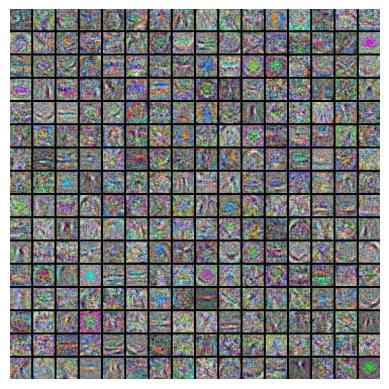

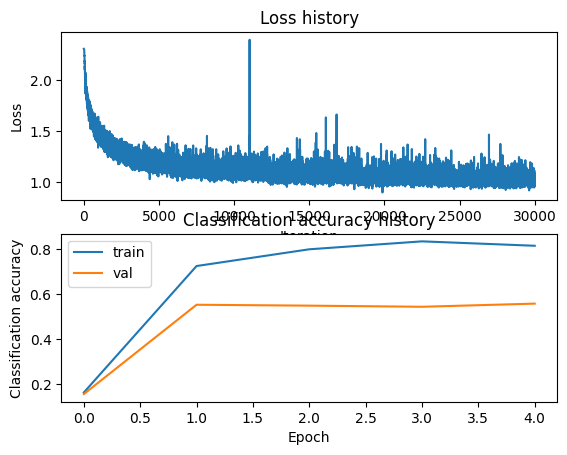

Test accuracy for best model:  0.558
Validation accuracy for the Worst model:  0.534


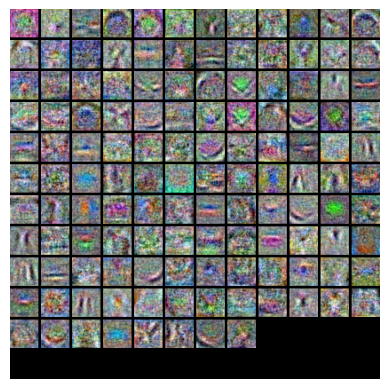

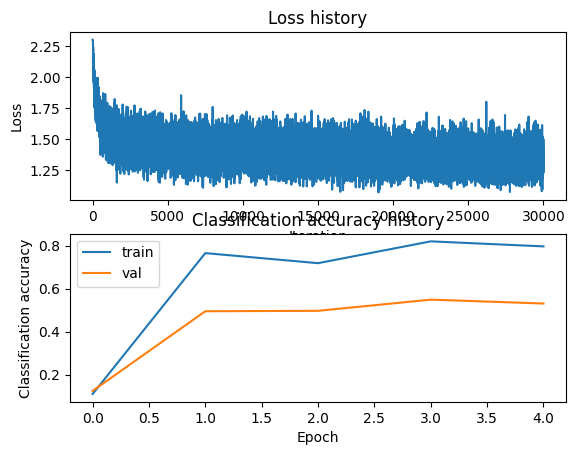

Test accuracy for the worst model:  0.519
Validation accuracy of Default model:  0.496


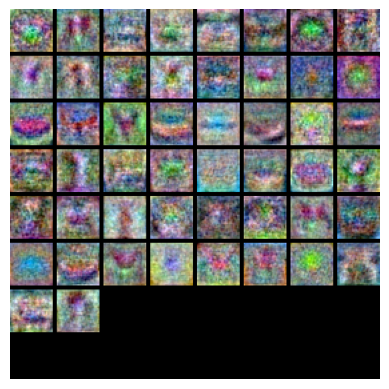

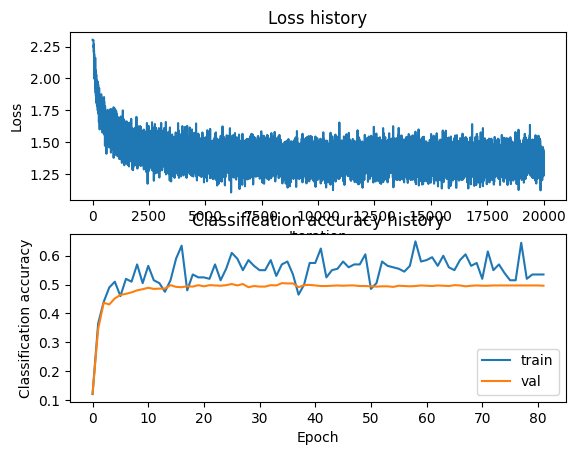

Test accuracy of Default model:  0.507


In [7]:
##########################Best Model######################
best_net = module_twolayernet.TwoLayerNetv4(input_size=input_size, hidden_size=256, output_size=num_classes)

# visualize the weights of the best network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=30000, batch_size=512,
            learning_rate=0.7 * 1e-3, learning_rate_decay=0.90,
            reg=0.20, verbose=True)

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy for best model: ', val_acc)
show_net_weights(best_net)


plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()


# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy for best model: ', test_acc)


#######################Worst Model#######################
worst_net = module_twolayernet.TwoLayerNetv4(input_size=input_size, hidden_size=128, output_size=num_classes)


# visualize the weights of the Worst network
stats = worst_net.train(X_train, y_train, X_val, y_val,
            num_iters=30000, batch_size=128,
            learning_rate=0.9 * 1e-3, learning_rate_decay=0.90,
            reg=0.30, verbose=True)

# Predict on the validation set
val_acc = (worst_net.predict(X_val) == y_val).mean()
print('Validation accuracy for the Worst model: ', val_acc)
show_net_weights(worst_net)

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (worst_net.predict(X_test) == y_test).mean()
print('Test accuracy for the worst model: ', test_acc)


######################Default Model###########################
default_net = module_twolayernet.TwoLayerNetv4(input_size=input_size, hidden_size=hidden_size, output_size=num_classes)

# visualize the weights of the best network
stats = default_net.train(X_train, y_train, X_val, y_val,
            num_iters=20000, batch_size=200,
            learning_rate=0.7 * 1e-3, learning_rate_decay=0.90,
            reg=0.20, verbose=True)

# Predict on the validation set
val_acc = (default_net.predict(X_val) == y_val).mean()
print('Validation accuracy of Default model: ', val_acc)
show_net_weights(default_net)

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (default_net.predict(X_test) == y_test).mean()
print('Test accuracy of Default model: ', test_acc)

### Question 4: Implement multi-layer perceptron using PyTorch library (10 points)

So far, we have implemented a two-layer network by explicitly writing down the expressions for the forward and backward computations and training algorithms using simple matrix multiplication primitives from the NumPy library.

However there are many libraries available designed make experimenting with neural networks faster by abstracting away the details into re-usable modules. One such popular open-source library is PyTorch (https://pytorch.org/). In this final question we will use the PyTorch library to implement the same two-layer network we did before and train it on the Cifar-10 dataset. However, extending a two-layer network to a three or four layered one is a matter of changing two-three lines of code using PyTorch. We will take advantage of this to experiment with deeper networks to improve the performance on the CIFAR-10 classification.

To install the pytorch library follow the instruction in
https://pytorch.org/get-started/locally/ . If you have access to a Graphics Processing
Unit (GPU), you can install the gpu verison and run the exercise on GPU for faster run
times. If not, you can install the cpu version (select cuda version None) and run on the
cpu. Having gpu access is not necessary to complete the exercise.  There are good tutorials
for getting started with pytorch on their website (https://pytorch.org/tutorials/).

a) Complete the code to implement a multi-layer perceptron network in the class
`MultiLayerPerceptron`. This includes instantiating the
required layers from `torch.nn` and writing the code for forward pass. Initially you 
should write the code for the same two-layer network we have seen before.
(3 points)

In [10]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
hidden_size = [50]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True
drop_prob=0.1

#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='../../data/exercise-2/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/exercise-2/',
                                          train=False,
                                          transform=norm_transform
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Using device: cuda
Files already downloaded and verified


In [11]:
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, drop_prob):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        # Make use of linear and relu layers from the torch.nn module                   #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())

        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_prob))

        
        layers.append(nn.Linear(hidden_layers[-1], num_classes))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return self.layers(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


model = MultiLayerPerceptron(input_size, hidden_size, num_classes, drop_prob).to(device)
print(model)

MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


b) Complete the code to train the network. Make use of the loss function `torch.nn.CrossEntropyLoss` to compute the loss and `loss.backward()` to compute the gradients. Once gradients are computed, `optimizer.step()` can be invoked to update the model. Your should be able to achieve similar performance ($>$ 48\% accuracy on the validation set) as in Q3. Report the final validation accuracy you achieve with a two-layer network. (3 points)

In [4]:
# Training
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        # if(i>2):
        #     break
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        #################################################################################
        # TODO: Implement the training code                                             #
        # 1. Pass the images to the model                                               #
        # 2. Compute the loss using the output and the labels.                          #
        # 3. Compute gradients and update the model using the optimizer                 #
        # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        optimizer.zero_grad()

        outputs = model(images.reshape(batch_size,-1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()), end='\r')
        total += labels.size(0)
        predicted = model(images.reshape(batch_size,-1))
        _ , predicted = torch.max(predicted, 1)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            ####################################################
            # TODO: Implement the evaluation code              #
            # 1. Pass the images to the model                  #
            # 2. Get the most confident predicted class        #
            ####################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            predicted = model(images.reshape(batch_size,-1))
            _ , predicted = torch.max(predicted, 1)

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validataion accuracy is: {} %'.format(100 * correct / total))

##################################################################################
# TODO: Now that you can train a simple two-layer MLP using above code, you can  #
# easily experiment with adding more layers and different layer configurations   #
# and let the pytorch library handle computing the gradients                     #
#                                                                                #
# Experiment with different number of layers (atleast from 2 to 5 layers) and    #
# record the final validation accuracies Report your observations on how adding  #
# more layers to the MLP affects its behavior. Try to improve the model          #
# configuration using the validation performance as the guidance. You can        #
# experiment with different activation layers available in torch.nn, adding      #
# dropout layers, if you are interested. Use the best model on the validation    #
# set, to evaluate the performance on the test set once and report it            #
##################################################################################

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Run the test code once you have your by setting train flag to false
# and loading the best model

best_model = None # torch.load()
best_model = torch.load('model.ckpt')
model.load_state_dict(best_model)
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        predicted = model(images.reshape(batch_size,-1))
        _ , predicted = torch.max(predicted, 1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Train accuracy is: 37.077551020408166 %408
Validataion accuracy is: 44.0 %
Train accuracy is: 45.326530612244895 %932
Validataion accuracy is: 46.5 %
Train accuracy is: 48.0 %45], Loss: 1.6181
Validataion accuracy is: 47.0 %
Train accuracy is: 49.724489795918366 %434
Validataion accuracy is: 48.7 %
Train accuracy is: 50.98367346938775 %4204
Validataion accuracy is: 50.3 %
Train accuracy is: 52.118367346938776 %746
Validataion accuracy is: 48.7 %
Train accuracy is: 52.7734693877551 %.2671
Validataion accuracy is: 52.3 %
Train accuracy is: 53.50204081632653 %3934
Validataion accuracy is: 51.4 %
Train accuracy is: 54.05102040816327 %2994
Validataion accuracy is: 51.0 %
Train accuracy is: 54.912244897959184 %3356
Validataion accuracy is: 51.5 %
Train accuracy is: 55.593877551020405 %4042
Validataion accuracy is: 52.5 %
Train accuracy is: 55.810204081632655 %1634
Validataion accuracy is: 52.0 %
Train accuracy is: 56.49183673469388 %.2166
Validataion accuracy is: 52.1 %
Train accuracy is: 57

### Experiments with different layers

#### Model 1 
Changing the number of layers to [256,128]

In [13]:
model_1 = MultiLayerPerceptron(input_size, [256,128], num_classes, drop_prob).to(device)

In [15]:
print("Model 1")
# Training
model_1.apply(weights_init)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=reg)
# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_1(images.reshape(batch_size,-1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()), end='\r')
        total += labels.size(0)
        predicted = model_1(images.reshape(batch_size,-1))
        _ , predicted = torch.max(predicted, 1)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model_1(images.reshape(batch_size,-1))
            _ , predicted = torch.max(predicted, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validataion accuracy is: {} %'.format(100 * correct / total))


with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model_1(images.reshape(batch_size,-1))
        _ , predicted = torch.max(predicted, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Model 1
Train accuracy is: 33.114285714285714 %875
Validataion accuracy is: 41.3 %
Train accuracy is: 44.86734693877551 %5787
Validataion accuracy is: 45.1 %
Train accuracy is: 49.01020408163265 %5773
Validataion accuracy is: 48.0 %
Train accuracy is: 51.840816326530614 %858
Validataion accuracy is: 49.2 %
Train accuracy is: 53.765306122448976 %798
Validataion accuracy is: 52.1 %
Train accuracy is: 55.53877551020408 %4353
Validataion accuracy is: 52.5 %
Train accuracy is: 57.148979591836735 %250
Validataion accuracy is: 52.1 %
Train accuracy is: 58.295918367346935 %289
Validataion accuracy is: 51.3 %
Train accuracy is: 59.795918367346935 %833
Validataion accuracy is: 53.3 %
Train accuracy is: 60.91836734693877 %.2115
Validataion accuracy is: 53.2 %
Train accuracy is: 61.98367346938775 %.1977
Validataion accuracy is: 54.7 %
Train accuracy is: 63.36938775510204 %.2638
Validataion accuracy is: 55.4 %
Train accuracy is: 64.2326530612245 %1.0704
Validataion accuracy is: 54.5 %
Train accurac

#### Model 2

Changin the number of neurons in each layers and increasing one more layer. 

In [18]:
model_2 = MultiLayerPerceptron(input_size, [512,256,128], num_classes, drop_prob).to(device)

In [19]:
print("Model 2")
# Training
# model_2.apply(weights_init)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate, weight_decay=reg)
# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_2(images.reshape(batch_size,-1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()), end='\r')
        total += labels.size(0)
        predicted = model_2(images.reshape(batch_size,-1))
        _ , predicted = torch.max(predicted, 1)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model_2(images.reshape(batch_size,-1))
            _ , predicted = torch.max(predicted, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validataion accuracy is: {} %'.format(100 * correct / total))


with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model_2(images.reshape(batch_size,-1))
        _ , predicted = torch.max(predicted, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Model 2
Train accuracy is: 41.487755102040815 %867
Validataion accuracy is: 44.6 %
Train accuracy is: 48.48367346938775 %5014
Validataion accuracy is: 48.3 %
Train accuracy is: 51.66530612244898 %3525
Validataion accuracy is: 50.1 %
Train accuracy is: 53.70816326530612 %4728
Validataion accuracy is: 50.7 %
Train accuracy is: 55.70204081632653 %3733
Validataion accuracy is: 52.9 %
Train accuracy is: 57.31836734693878 %2153
Validataion accuracy is: 52.4 %
Train accuracy is: 58.69183673469388 %1904
Validataion accuracy is: 53.3 %
Train accuracy is: 60.33061224489796 %2080
Validataion accuracy is: 53.8 %
Train accuracy is: 61.57142857142857 %1870
Validataion accuracy is: 55.7 %
Train accuracy is: 62.79183673469388 %.0877
Validataion accuracy is: 56.7 %
Train accuracy is: 64.22244897959183 %.1073
Validataion accuracy is: 55.7 %
Train accuracy is: 65.5 %245], Loss: 1.1090
Validataion accuracy is: 56.3 %
Train accuracy is: 66.61632653061224 %.9793
Validataion accuracy is: 55.3 %
Train accurac

#### Model 3

- Increased the number of layers
- Increased the number of epochs
- Increase the regularization 

In [28]:
model_3 = MultiLayerPerceptron(input_size, [512,256,128,64], num_classes, drop_prob).to(device)

In [29]:
print("Model 3")
# Training
# model_2.apply(weights_init)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate, weight_decay=reg)
# Train the model
lr = learning_rate
total_step = len(train_loader)
num_epochs = 40
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_3(images.reshape(batch_size,-1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()), end='\r')
        total += labels.size(0)
        predicted = model_3(images.reshape(batch_size,-1))
        _ , predicted = torch.max(predicted, 1)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model_3(images.reshape(batch_size,-1))
            _ , predicted = torch.max(predicted, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validataion accuracy is: {} %'.format(100 * correct / total))

        

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model_3(images.reshape(batch_size,-1))
        _ , predicted = torch.max(predicted, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Model 3
Train accuracy is: 38.118367346938776 %880
Validataion accuracy is: 45.7 %
Train accuracy is: 46.36938775510204 %5128
Validataion accuracy is: 48.4 %
Train accuracy is: 49.83469387755102 %4487
Validataion accuracy is: 50.6 %
Train accuracy is: 51.83061224489796 %3625
Validataion accuracy is: 49.4 %
Train accuracy is: 53.977551020408164 %349
Validataion accuracy is: 51.7 %
Train accuracy is: 55.9 %45], Loss: 1.2723
Validataion accuracy is: 52.3 %
Train accuracy is: 57.142857142857146 %088
Validataion accuracy is: 50.8 %
Train accuracy is: 58.43061224489796 %0934
Validataion accuracy is: 51.3 %
Train accuracy is: 60.31224489795918 %1317
Validataion accuracy is: 53.0 %
Train accuracy is: 61.251020408163264 %1819
Validataion accuracy is: 54.9 %
Train accuracy is: 62.522448979591836 %1106
Validataion accuracy is: 52.5 %
Train accuracy is: 63.9 %245], Loss: 0.9049
Validataion accuracy is: 56.1 %
Train accuracy is: 65.4938775510204 %1.0114
Validataion accuracy is: 55.1 %
Train accurac

### Report Question 4

| S.No | Name          | Hyper-Parameters                                                                                               | Train Set Accuracy | Val Set Accuracy |Test Set Accuracy|
|------|---------------|----------------------------------------------------------------------------------------------------------------|------------------|-------------------|-------------------|
| 1    | Model 1    | Number of neurons in hidden layers: [256,128] |70.95| 55.8 %            | 57.2 %             |
| 2    | Model 2   | Number of neurons in hidden layers: [512,256,128] |74.72| 56.7 %             | 56.6 %             |
| 3    | Model 3 |Number of neurons in hidden layers: [512,256,128,64]  |89.31|56.6 %            | 54.9 %             |

- The accuracy of model 3 on test set is less than val set. The diffference between the acuracy of validation set and train set is also huge. This is the case of overfitting. Better regularization factor may be helpful. 
- Similarly, model 2 is overfitted but with lesser margin when compared to model 3. However the model is performing consistently on val and test set. 
- Model 1 has more accuracy on test set when compared to val set. Model can learn more. Increasing the number of epochs will help us to better understand the model capabilities. As of now, 20 epochs, the model is underfitting to val sets

### Question 5: Modularized Implementation (5 points)

In this part, we would like to familiarize ourselves with how often the training and evaluation is implemented using PyTorch. Technically, what we have already written above for previous questions already does what is needed. However, this might not be easily scalable when we want to explore different models, criterions, and hyper-parameters. We would need a proper config system to make changes easier and re-usable components so that we don't have to re-implement same thing multiple times.

For this task, we ask you to basically plug-in the implementations from above cells (either what you've written or what was already given) into appropriate changes. Specifically, you need to implement the methods from `trainers/mlp_trainer.py`. Note that the class inherits from `BaseTrainer`, which also has many empty methods, **but you should only implement each one in the indicated class and not in the other**

Specifically, you need to implement the indicated snipets in the following sections:

1. In `trainers/mlp_trainer.py` in class `MLPTrainer`:

`_train_epoch()`, `evaluate()`, `save_model()`, `load_model()`.

2. In `trainers/base_trainer.py` in class `BaseTrainer`:

`_do_evaluate()`


3. In `models/mlp/metric.py` in class `TopKAccucacy`:

`compute()`

4. In `models/mlp/model.py` in class `MultiLayerPerceptron`:

`__init__()`, `build_model()`, `forward()`

In [3]:
from utils.parse_config import ConfigParser
from trainers.mlp_trainer import MLPTrainer
import data_loaders.data_loaders as module_data

As you already know good hyperparams from the previous question, simply set those in the `../../cfgs/exercise-2/mlp_cifar10.json` file, to only train once with the right params!

In [4]:
config = ConfigParser.wo_args('../../cfgs/exercise-2/mlp_cifar10.json')

train_data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = train_data_loader.split_validation()

trainer = MLPTrainer(config, train_loader=train_data_loader, eval_loader=valid_data_loader)

MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [5]:
trainer.train() 
checkpoint_path = '../../saved/models/CIFAR10_MLP/latest.ckpt'
trainer.save_model(path=checkpoint_path)
# Note that the Trainer also saves some intermediate checkpoints itself
# according to `save_period` in the config

==> Start Training Epoch 1/20, lr=0.001000 


Train Epoch: 1 Loss: 1.512303: : 100% 45056/45056 [00:15<00:00, 2974.48it/s]

==> Finished Epoch 1/20.
    epoch          : 1
    loss           : 1.8171375251629136
    top1           : 0.3331533104482323
    top5           : 0.8356489701704546
==> Start Training Epoch 2/20, lr=0.001000 



Train Epoch: 2 Loss: 1.486829: : 100% 45056/45056 [00:10<00:00, 4304.12it/s]

==> Finished Epoch 2/20.
    epoch          : 2
    loss           : 1.5812912766229024
    top1           : 0.4392681699810606
    top5           : 0.8978727706755051
==> Start Training Epoch 3/20, lr=0.001000 



Train Epoch: 3 Loss: 1.604721: : 100% 45056/45056 [00:10<00:00, 4349.34it/s]

==> Finished Epoch 3/20.
    epoch          : 3
    loss           : 1.4859525747597218
    top1           : 0.47184984611742425
    top5           : 0.9134607796717172
==> Start Training Epoch 4/20, lr=0.001000 



Train Epoch: 4 Loss: 1.376805: : 100% 45056/45056 [00:10<00:00, 4445.70it/s]

==> Finished Epoch 4/20.
    epoch          : 4
    loss           : 1.4373059320178898
    top1           : 0.4901875197285354
    top5           : 0.9207628038194445
==> Start Training Epoch 5/20, lr=0.001000 



Train Epoch: 5 Loss: 1.331648: : 100% 45056/45056 [00:10<00:00, 4335.91it/s]

==> Finished Epoch 5/20.
++> Evaluate at epoch 5 ...



Val Loss: 1.331648: : 100% 5120/5120 [00:07<00:00, 686.64it/s]

++> Evaluate epoch 5 Finished.
    epoch          : 5
    loss           : 1.3889259472489357
    top1           : 0.5088285195707071
    top5           : 0.9287972498421717
    eval_loss      : 1.3316478729248047
    eval_top1      : 0.5107421875
    eval_top5      : 0.93203125
==> Start Training Epoch 6/20, lr=0.001000 



Train Epoch: 6 Loss: 1.087331: : 100% 45056/45056 [00:10<00:00, 4429.83it/s]

==> Finished Epoch 6/20.
    epoch          : 6
    loss           : 1.3353949575261637
    top1           : 0.5243746054292929
    top5           : 0.9360894097222222
==> Start Training Epoch 7/20, lr=0.001000 



Train Epoch: 7 Loss: 1.591141: : 100% 45056/45056 [00:10<00:00, 4493.59it/s]

==> Finished Epoch 7/20.
    epoch          : 7
    loss           : 1.3023816276003013
    top1           : 0.5377554845328283
    top5           : 0.9408464528093435
==> Start Training Epoch 8/20, lr=0.001000 



Train Epoch: 8 Loss: 1.318752: : 100% 45056/45056 [00:10<00:00, 4399.71it/s]

==> Finished Epoch 8/20.
    epoch          : 8


    loss           : 1.2691261974925345
    top1           : 0.5481154316603536
    top5           : 0.9445603495896464
==> Start Training Epoch 9/20, lr=0.001000 


Train Epoch: 9 Loss: 1.274265: : 100% 45056/45056 [00:10<00:00, 4387.78it/s]

==> Finished Epoch 9/20.
    epoch          : 9
    loss           : 1.2421433973041447
    top1           : 0.5611436631944445
    top5           : 0.9470190183080809
==> Start Training Epoch 10/20, lr=0.001000 



Train Epoch: 10 Loss: 1.229852: : 100% 45056/45056 [00:10<00:00, 4428.84it/s]

==> Finished Epoch 10/20.
++> Evaluate at epoch 10 ...



Val Loss: 1.229852: : 100% 5120/5120 [00:07<00:00, 695.91it/s]

++> Evaluate epoch 10 Finished.
    epoch          : 10
    loss           : 1.2188985357907685
    top1           : 0.567742858270202
    top5           : 0.9500942037563131
    eval_loss      : 1.2298521995544434
    eval_top1      : 0.5318359375
    eval_top5      : 0.93671875
Saving checkpoint: ../../saved/models/CIFAR10_MLP/0522_192522/E10_model.ckpt ...


Checkpoint saved.
==> Start Training Epoch 11/20, lr=0.001000 


Train Epoch: 11 Loss: 1.388128: : 100% 45056/45056 [00:10<00:00, 4315.56it/s]

==> Finished Epoch 11/20.
    epoch          : 11
    loss           : 1.1980779033831574
    top1           : 0.5760337752525252
    top5           : 0.9511028251262627
==> Start Training Epoch 12/20, lr=0.001000 



Train Epoch: 12 Loss: 1.218061: : 100% 45056/45056 [00:10<00:00, 4323.17it/s]

==> Finished Epoch 12/20.
    epoch          : 12
    loss           : 1.1752151421863923
    top1           : 0.5837328361742424
    top5           : 0.9550485321969696
==> Start Training Epoch 13/20, lr=0.001000 



Train Epoch: 13 Loss: 0.978816: : 100% 45056/45056 [00:10<00:00, 4385.43it/s]

==> Finished Epoch 13/20.
    epoch          : 13
    loss           : 1.1574797257781029
    top1           : 0.589562618371212
    top5           : 0.9557488952020201


==> Start Training Epoch 14/20, lr=0.001000 


Train Epoch: 14 Loss: 1.234786: : 100% 45056/45056 [00:10<00:00, 4406.98it/s]

==> Finished Epoch 14/20.
    epoch          : 14
    loss           : 1.1386679529466412
    top1           : 0.595754912405303
    top5           : 0.9577464094065656
==> Start Training Epoch 15/20, lr=0.001000 



Train Epoch: 15 Loss: 1.249584: : 100% 45056/45056 [00:10<00:00, 4397.02it/s]

==> Finished Epoch 15/20.
++> Evaluate at epoch 15 ...



Val Loss: 1.249584: : 100% 5120/5120 [00:07<00:00, 707.62it/s]

++> Evaluate epoch 15 Finished.
    epoch          : 15
    loss           : 1.126457366245714
    top1           : 0.6009040601325757
    top5           : 0.9591027462121212
    eval_loss      : 1.2495837211608887
    eval_top1      : 0.533984375
    eval_top5      : 0.938671875
==> Start Training Epoch 16/20, lr=0.001000 



Train Epoch: 16 Loss: 1.193238: : 100% 45056/45056 [00:10<00:00, 4503.68it/s]

==> Finished Epoch 16/20.
    epoch          : 16
    loss           : 1.108985917812044
    top1           : 0.607485992739899
    top5           : 0.9590435606060606
==> Start Training Epoch 17/20, lr=0.001000 



Train Epoch: 17 Loss: 1.019456: : 100% 45056/45056 [00:10<00:00, 4351.16it/s]

==> Finished Epoch 17/20.
    epoch          : 17
    loss           : 1.1022218076342887
    top1           : 0.6113256589330809
    top5           : 0.9604689472853536
==> Start Training Epoch 18/20, lr=0.001000 



Train Epoch: 18 Loss: 1.161371: : 100% 45056/45056 [00:10<00:00, 4429.56it/s]

==> Finished Epoch 18/20.
    epoch          : 18
    loss           : 1.0869883556257596
    top1           : 0.6148003472222222
    top5           : 0.9616625236742423
==> Start Training Epoch 19/20, lr=0.001000 



Train Epoch: 19 Loss: 0.994205: : 100% 45056/45056 [00:10<00:00, 4406.14it/s]

==> Finished Epoch 19/20.
    epoch          : 19
    loss           : 1.071452257308093
    top1           : 0.620233092645202
    top5           : 0.9635663273358586
==> Start Training Epoch 20/20, lr=0.001000 



Train Epoch: 20 Loss: 1.207374: : 100% 45056/45056 [00:10<00:00, 4343.38it/s]

==> Finished Epoch 20/20.
++> Evaluate at epoch 20 ...



Val Loss: 1.207374: : 100% 5120/5120 [00:07<00:00, 675.06it/s]

++> Evaluate epoch 20 Finished.
    epoch          : 20
    loss           : 1.0650396363979036
    top1           : 0.6218360361426768
    top5           : 0.9649127998737373
    eval_loss      : 1.2073739767074585
    eval_top1      : 0.53984375
    eval_top5      : 0.937890625
Saving checkpoint: ../../saved/models/CIFAR10_MLP/0522_192522/E20_model.ckpt ...


Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_MLP/latest.ckpt ...
Checkpoint saved.


In [6]:
test_loader = getattr(module_data, config['data_loader']['type'])(
                      config['data_loader']['args']['data_dir'],
                      batch_size=512,
                      shuffle=False,
                      validation_split=0.0,
                      training=False,
                      num_workers=2
                    )

trainer.load_model(path='../../saved/models/CIFAR10_MLP/latest.ckpt') 
# Or replace the path with an epoch you already know has a good accuracy.

result = trainer.evaluate(loader=test_loader)

print(result)

Loading checkpoint: ../../saved/models/CIFAR10_MLP/latest.ckpt ...
Checkpoint loaded.
++> Evaluate at epoch 20 ...


Val Loss: 1.207374: : 100% 10240/10240 [00:11<00:00, 866.43it/s]

++> Evaluate epoch 20 Finished.
{'loss': 1.2073739767074585, 'top1': 0.5219898897058823, 'top5': 0.9320025275735293}
